In [1]:
#https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification

Train shape: (2000, 21)
Test shape: (1000, 21)
   battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   
3            615     1          2.5         0   0       0          10    0.8   
4           1821     1          1.2         0  13       1          44    0.6   

   mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0        188        2  ...         20       756  2549     9     7         19   
1        136        3  ...        905      1988  2631    17     3          7   
2        145        5  ...       1263      1716  2603    11     2          9   
3        131        6  ...       1216      1786  2769    16     8         11   
4        141        2  ...       1208      1212  1411     8     2       

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Baseline Validation Accuracy: 0.9150000214576721
Optimized Validation Accuracy: 0.9449999928474426


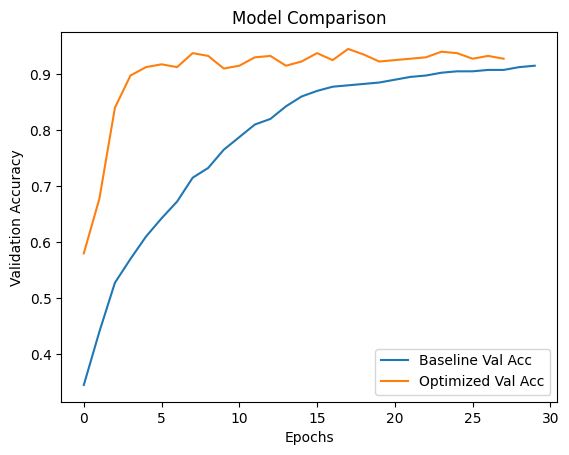

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       100
           1       0.91      0.93      0.92       100
           2       0.97      0.89      0.93       100
           3       0.96      0.98      0.97       100

    accuracy                           0.94       400
   macro avg       0.95      0.95      0.94       400
weighted avg       0.95      0.94      0.94       400



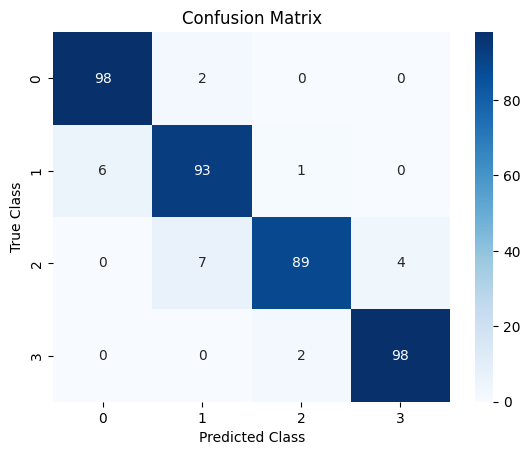

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Sample predictions with all features:
    id  battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  \
0   1           1043     1          1.8         1  14       0           5   
1   2            841     1          0.5         1   4       1          61   
2   3           1807     1          2.8         0   1       0          27   
3   4           1546     0          0.5         1  18       1          25   
4   5           1434     0          1.4         0  11       1          49   

   m_dep  mobile_wt  ...  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0    0.1        193  ...        226      1412  3476    12     7          2   
1    0.8        191  ...        746       857  3895     6     0          7   
2    0.9        186  ...       1270      1366  2396    17    10         10   
3    0.5         96  ...        295      1752  3893    10     0          7   
4    0.5        108  ...        749       810  1773    15     8     

In [4]:
# ===============================
# Step 1: Import Libraries
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# ===============================
# Step 2: Load Datasets
# ===============================
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print(train_df.head())


# ===============================
# Step 3 (Fixed): Preprocessing
# ===============================
X = train_df.drop("price_range", axis=1)
y = train_df["price_range"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Drop "id" from test.csv before scaling
X_test_final = scaler.transform(test_df.drop("id", axis=1))

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)








# ===============================
# Step 4: Baseline ANN Classifier
# ===============================
model_base = Sequential([
    Dense(32, activation="relu", input_dim=X_train.shape[1]),
    Dense(4, activation="softmax")  # 4 classes
])

model_base.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_base = model_base.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=0
)

loss_base, acc_base = model_base.evaluate(X_val, y_val, verbose=0)
print("Baseline Validation Accuracy:", acc_base)

# ===============================
# Step 5: Optimized ANN Classifier with Dropout
# ===============================
model_opt = Sequential([
    Dense(128, activation="relu", input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(4, activation="softmax")
])

model_opt.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6)

history_opt = model_opt.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

loss_opt, acc_opt = model_opt.evaluate(X_val, y_val, verbose=0)
print("Optimized Validation Accuracy:", acc_opt)

# ===============================
# Step 6: Learning Curve Comparison
# ===============================
plt.plot(history_base.history["val_accuracy"], label="Baseline Val Acc")
plt.plot(history_opt.history["val_accuracy"], label="Optimized Val Acc")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Model Comparison")
plt.show()

# ===============================
# Step 7: Classification Report & Confusion Matrix
# ===============================
y_val_pred = model_opt.predict(X_val)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)

print("Classification Report:\n", classification_report(y_val, y_val_pred_labels))

cm = confusion_matrix(y_val, y_val_pred_labels)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=[0,1,2,3],
            yticklabels=[0,1,2,3])
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

# ===============================
# Step 8: Predictions on Test Data
# ===============================
test_predictions = model_opt.predict(X_test_final)
test_labels = np.argmax(test_predictions, axis=1)

# Add predictions to original test dataframe
submission = test_df.copy()
submission["price_range"] = test_labels

# Save submission file
submission.to_csv("submission.csv", index=False)

print("Sample predictions with all features:\n", submission.head())


In [3]:
submission.head()

,id,price_range
0,0,3
1,1,3
2,2,2
3,3,3
4,4,1
